In [1]:
import graphviz
import pydot
import pywrapfst as pfst
from pywrapfst import compose
# import fst
import nltk
import re
import os
from fst_funcs import create_word_acceptor, analyse_state, get_lex, get_lang, get_rm_dupes, get_rm_blanks, speech_to_text, add_blank_loops, create_frame_acceptor
import numpy as np
import csv
import editdistance
from multiprocessing.dummy import Pool as ThreadPool 

%load_ext line_profiler
%load_ext memory_profiler

In [2]:
LM_expr = "^(.*)\.pru$"
folder_name = "../lang_model"
file_list = [os.path.join(folder_name, fname) for fname in os.listdir(folder_name)]
pruned_models = [re.match(LM_expr, filename).group(1) for filename in file_list if re.match(LM_expr, filename)]
pruned_models

['../lang_model/3-gram-1',
 '../lang_model/3-gram-3',
 '../lang_model/3-gram-0',
 '../lang_model/3-gram-2']

In [3]:
big_lm_name = folder_name+"/3-gram-1.pru"
small_lm_name = folder_name+"/3-gram-3.pru"
big_lang_fst = pfst.Fst.read(big_lm_name )
small_lang_fst = pfst.Fst.read(small_lm_name )
def get_arcs(fst, state):
    arcs = fst.arcs(state)
    arcs.seek(100000)
    
    for a in arcs:
        continue

In [4]:
idx_to_label = {arc.ilabel : idx for idx, arc in enumerate(big_lang_fst.arcs(0))}

In [5]:
%lprun -f get_arcs get_arcs(big_lang_fst, 0)

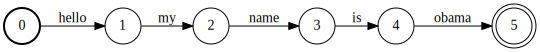

In [6]:
create_word_acceptor(["hello", "my", "name", "is", "obama"], big_lang_fst.input_symbols())

In [7]:
st_w_blank = pfst.SymbolTable().read_text("phoneme-symb-table-with-blank.txt")
st_no_blank = pfst.SymbolTable().read_text("phoneme-symb-table.txt")

In [8]:
lex_loaded = pfst.Fst.read("../lex_model/lex-uw.fst")
def word_end_iter():
    for i in range(40, 53):
        yield (i, 0)

lex_loaded = pfst.Fst.read("../lex_model/lex-uw.fst")
i_table = lex_loaded.input_symbols()
o_table = lex_loaded.output_symbols()
LG = pfst.compose(lex_loaded, small_lang_fst)
LG = pfst.determinize(LG)
LG=LG.minimize()
LG=LG.rmepsilon()
# LG = LG.push()

for i in range(40,53):
    LG.relabel_pairs(word_end_iter())
    print "Relabelled <w{}>".format(i)
LG = LG.set_input_symbols(st_no_blank)

Relabelled <w40>
Relabelled <w41>
Relabelled <w42>
Relabelled <w43>
Relabelled <w44>
Relabelled <w45>
Relabelled <w46>
Relabelled <w47>
Relabelled <w48>
Relabelled <w49>
Relabelled <w50>
Relabelled <w51>
Relabelled <w52>


In [9]:
nltk.corpus.cmudict.dict()["he"]

[[u'HH', u'IY1']]

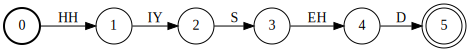

In [10]:
test_phons_no_blank = create_frame_acceptor("HH IY S EH D", st_no_blank)
test_phons_w_blank = create_frame_acceptor("HH IY S EH EH - D D", st_w_blank)
test_phons_no_blank

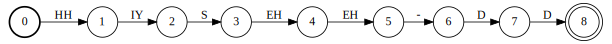

In [11]:
test_phons_w_blank

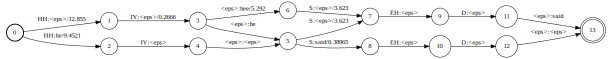

In [12]:
pfst.compose(test_phons_no_blank, LG)

In [13]:
rm_dupes = get_rm_dupes()
rm_blanks = get_rm_blanks()
reducer = pfst.compose(rm_dupes, rm_blanks)

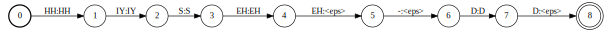

In [14]:
pfst.compose(test_phons_w_blank, reducer)

In [15]:
full_fst = pfst.compose(reducer, LG)


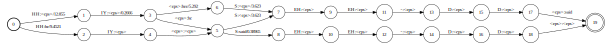

In [16]:
comp = pfst.compose(test_phons_w_blank, full_fst)
comp
# Why is there weight on arcs with a non-word output? 
# Does pfst correctly push weight of the language model??

In [17]:
# full_fst.push()
# pfst.compose(test_phons_w_blank, full_fst)
# Why is there weight on arcs with a non-word output? 
# Does pfst correctly push weight of the language model??

In [18]:
# full_fst.write("full_fst.fst")

In [19]:
# full_fst = add_blank_loops(LG)
# full_fst.write("full_fst_only_blank_loops.fst")

In [21]:
def strarc(fst, arc):
    return str(fst.input_symbols().find(arc.ilabel))+":"+str(fst.output_symbols().find(arc.olabel)) 

In [40]:
def get_extensions_inner(fst, state, used_move, passed_word, last_arc, input_idx, store):

    extensions = []
    print "Getting extensions from {} using {}".format(state, input_idx)
    if not store[state]:
        arcs =  fst.arcs(state)
        store[state] = {}
        for arc in arcs:
            print arc.ilabel
            store[state][arc.ilabel] = arc
    eps_arc = store[state].get(0, None)
    idx_arc = store[state].get(input_idx, None)
    if eps_arc:
        extensions.extend(get_extensions_inner(fst, eps_arc.nextstate, used_move, eps_arc.olabel, eps_arc, input_idx, store))

    if idx_arc and not used_move:
        extensions.extend(get_extensions_inner(fst, idx_arc.nextstate, True, passed_word, idx_arc, input_idx, store))

#     else:
#         for e in arcs:
#             if e.ilabel == 0: # don't need a move anyway
#                 if fst == big_lang_fst:
#                     print "                    " + "crossing {}".format(strarc(fst, e))
#     #             assert e.olabel != 0 # shouldn't have epsilon:epsilon arcs
#                 assert not passed_word # there shouldn't be more than one word outputted per extension
#                 extensions.extend(get_extensions_inner(fst, e.nextstate, used_move, e.olabel, e, input_idx))
#             elif (e.ilabel == input_idx and not used_move): # use up your move
#                 if fst == big_lang_fst:
#                     print "                    " + "crossing {}".format(strarc(fst, e))
#                 extensions.extend(get_extensions_inner(fst, e.nextstate, True, passed_word, e, input_idx))
#             else: # no moves left
#                 continue
    
    if extensions:
        return [[(last_arc, state)]+ext for ext in extensions] + ([[(last_arc,state)]] if last_arc and  last_arc.ilabel!=0 else [])
    else:
        return [[(last_arc,state)]]
    
def get_extensions(fst, start_state, input_idx, store):
    return [a[1:] for a in get_extensions_inner(fst, start_state, False, False, None, input_idx, store)]

In [41]:
full_fst.input_symbols().find(40)

'-'

In [42]:
def beam_search_otf(fst, lfst, probs, T, init_weight, width, alpha, beta):
    fst_store = {}
    lfst_store={}
    for ph in fst.states():
        fst_store[ph] = {}
    for lph in lfst.states():
        lfst_store[lph] = {}
    
    n_phons_incl_blank = 40
    root = fst.start()
    hyps = [[(None, root.__int__())]]
    acoustic_weights = [init_weight]
    lang_weights = [0.]
    cohyps = [[(None, lfst.start().__int__())]]
    cohyp_weights = [0.]
    out_idxs = [[]]
    input_symbols = fst.input_symbols()
    output_symbols = fst.output_symbols()
    print "T = {}".format(T)
    nlps = -np.log(probs)
    big_lang_root = lfst.start()
    
    for t in range(T):
        print "t={}".format(t)
        print "hyps={}".format(hyps[:5]) + ("..." if len(hyps)>5 else "") 
#         print "t={}, H = {}".format(t, cohyps)
        new_hyps = []
        new_acoustic_weights = []
        new_lang_weights = []
        new_cohyps = []
        new_cohyp_weights = []
        for k, h in enumerate(hyps):
            ch = cohyps[k]
            print "    "+"k= {}, h= {}, ch = {}".format(k, "..."+str(h[-3:]), "..."+str(ch[-3:]))
            last_cohyp_arc, last_cohyp_state = cohyps[k][-1]
            # iterate over non-eps inputs 
            for phon_symb_idx in range(1, n_phons_incl_blank+1):
                phon = input_symbols.find(phon_symb_idx)
                print "        " + "Inputting {}".format(phon)
                # get the path extensions given this input
                exts = get_extensions(fst, h[-1][1], phon_symb_idx, fst_store) 
                
                for ext in exts:
                    print "            " + "Extending hyp by {}".format([(input_symbols.find(q.ilabel), output_symbols.find(q.olabel), r) for q, r in ext])
                    final_ext_arc, final_ext_state = ext[-1] # the extension always ends on the word outputting arc
                    ext_word = final_ext_arc.olabel
                    new_hyps.append(h+ext) 
                    if ext_word!=0:
                        print "            "+ "Inputting \'{}\' to B".format(output_symbols.find(ext_word))
                        # non-epsilon output symbol
                        cohyp_exts = get_extensions(lfst, last_cohyp_state, ext_word, lfst_store)
                        #assert len(cohyp_exts) == 1 # there should actually only be one cohyp extension given a word
                        cohyp_ext_weights = [sum([l.weight.__float__() for l, x in ch_ext]) for ch_ext in cohyp_exts]
                        v = np.argmin(cohyp_ext_weights)
                        new_cohyps.append(cohyps[k]+cohyp_exts[v])
                        new_cohyp_weights.append(cohyp_weights[k]+cohyp_ext_weights[v]-beta)
                        new_lang_weights.append(cohyp_weights[k]+cohyp_ext_weights[v]-beta) # RESCORE!
                    else:
                        new_cohyps.append(cohyps[k])
                        new_cohyp_weights.append(cohyp_weights[k])
                        extweight = sum([m.weight.__float__() for m, y in ext]) 
                        new_lang_weights.append(lang_weights[k] + extweight)
                    
                    # non-epsilon input symbol
                    phon_probs_idx = phon_symb_idx-1
                    new_acoustic_weights.append(acoustic_weights[k]+nlps[t][phon_probs_idx])
        new_total_weights = np.asarray(new_lang_weights)*alpha + np.asarray(new_acoustic_weights)
        best_hyp_idxs = np.argsort(new_total_weights)[:width]
        hyps =     [new_hyps[j]     for j in best_hyp_idxs]
        weights =  [new_weights[j]  for j in best_hyp_idxs]
        cohyps =   [new_cohyps[j]     for j in best_hyp_idxs]
        cohyp_weights = [new_cohyp_weights[j] for j in best_hyp_idxs]
        

        
    final_hyp_idxs = [i for i in range(len(hyps)) if fst.final(hyps[i][-1]).to_string != "Infinity"]
    final_cohyps = [cohyps[i] for i in final_hyp_idxs]
    final_weights = [weights[i] for i in final_hyp_idxs]
    return final_cohyps, final_weights

In [43]:
get_extensions(comp, 3, comp.input_symbols().find("S"))

TypeError: get_extensions() takes exactly 4 arguments (3 given)

In [44]:
test_probs = np.load("../../acoustic/densenet_phon_nospace_b3.l5.f128.k7.relu_test_probs.npy")
# test_probs.shape
test_input_lens = np.load("../../acoustic/test_input_lens.npy")
# test_input_lens.shape
test_ids = np.load("../../acoustic/test_ids.npy")
# test_ids.shape
print test_ids[0]

2961-960-0002.flac


In [45]:
test_word_label_file = open("../../acoustic/asset/data/preprocess/meta/test_word.csv", "r")
csv_reader = csv.reader(test_word_label_file)
all_test_word_labels = {a[0]:a[1:] for a in csv_reader}
test_word_labels = []
for point_id in test_ids:
    test_word_labels.append(all_test_word_labels[point_id])

In [46]:
def beam_search_wrapper(fst, lfst, width, alpha, beta, init_weight):
    return lambda x: beam_search_otf(fst, 
                                           lfst,
                                              x[0], \
                                              x[1],\
                                              init_weight, \
                                              width , \
                                              alpha ,\
                                              beta)

WIDTH = 50
ALPHA = 0.6
BETA = 1.
INIT_WEIGHT = 0.

In [47]:
def test_beam_search(idxs):
#     pool = ThreadPool(4) 
    results = [beam_search_wrapper(full_fst, big_lang_fst, WIDTH, ALPHA, BETA, INIT_WEIGHT)\
                   ((test_probs[idx], test_input_lens[idx])) for idx in idxs]
#     pool.close() 
#     pool.join() 
    # lowest weight is always first
#     cohyp, best_weight = results[0]
#     print results[0]
    total_true_words = 0
    total_errs = 0
    for i, pair in enumerate(results):
        cohyps, weights = pair
        best_cohyp, best_weight = cohyps[0], weights[0]
        best_out = [big_lang_fst.output_symbols().find(e.olabel) for e, x in cohyp]
        true_words = test_word_labels[idxs[i]]
        lev_dist = editdistance.eval(best_out, true_words)
        n_words = len(true_words)
        total_errs += lev_dist
        total_true_words += n_words
#         print "Prediction:"
#         print " ".join(best_out), best_weight
#         print
#         print "True answer:"
#         print " ".join(true_words)
#         print
#         print "Levenshtein distance: {}/{}".format(editdistance.eval(best_out, true_words), len(true_words))
#         break
    print "Final WER: {}".format(float(total_errs)/total_true_words)

In [48]:
%lprun -f get_extensions_inner test_beam_search(range(1))

T = 480
t=0
hyps=[[(None, 0)]]
    k= 0, h= ...[(None, 0)], ch = ...[(None, 1)]
        Inputting AA
Getting extensions from 0 using 1
40
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
17
16
10
7
6


KeyError: 0

In [237]:
lev_dist

NameError: name 'lev_dist' is not defined

In [ ]:
lex, lang = get_lex(64000), get_lang(lang_model_name)
lexlang = pfst.compose(lex, lang)
lexlang=pfst.determinize(lexlang)
lexlang=lexlang.minimize()
# print "Start node is {}".format(lang.start())
# for k in lang.arcs(lang.start()):
#     print lang.input_symbols().find(k.ilabel), lang.output_symbols().find(k.olabel), k.weight, k.nextstate
# lang = lang.delete_states([5])

First 10 items in S are:
[[u'the', 7.615819], [u'to', 7.263301], [u'of', 7.242066], [u'a', 7.222159], [u'and', 7.210459], [u'in', 7.173804], [u'that', 6.843069], [u"'s", 6.838454], [u'for', 6.83241], [u'on', 6.775705]]
Last 10 items in S are:
[[u'gilliard', 1.69897], [u'benda', 1.69897], [u'hiaasen', 1.69897], [u'preppie', 1.69897], [u'sledd', 1.69897], [u'abedi', 1.69897], [u'mccreery', 1.69897], [u'howat', 1.69897], [u'credito', 1.69897], [u'vers', 1.69897]]


In [129]:
nltk.corpus.cmudict.dict()["'m"]

[[u'AH0', u'M']]

In [23]:
%lprun -f beam_search_full_comp beam_search_full_comp(full_fst, -np.log(test_probs[0][:input_lens[0]]),\
                                init_weight = 1., \
                                width = 10, \
                                alpha = 0.,\
                                beta = 0.)

UsageError: Could not find function u'beam_search_full_comp'.
NameError: name 'beam_search_full_comp' is not defined


In [136]:
cohyps, weights = beam_search_full_comp(full_fst, -np.log(test_probs[0][:input_lens[0]]),\
                                init_weight = 1., \
                                width = 10, \
                                alpha = 0.5,\
                                beta = 0.2)

T = 480
